<h1>Algoritmo Genético - Trabajo IA 2018</h1>
Integrantes

- Sebastian Gaete
- Elard Koch
- Israel Díaz
- Francisco González
- Humberto Campos

**notas**<br>
representación de individuo:
diccionario de python, el cual posee las siguientes claves,valores:

- **doors**: lista de puertas asociadas
- **ticks**: cantidad de ticks promedio del individuo
- **gen**: generación del individuo

una población de  individuos corresponderá a una lista de diccionarios

In [23]:
netlogo = None

In [24]:
import platform
import pyNetLogo
import random

netlogo_gui=False #ejecutar netlogo con interfaz grafica (True = si, False = no)
current_gen = 0 #contador de la generación actual
max_gen=50 #total de generaciones
n_doors = 5 #numero de puertas a ubicar
pop_size=20 #tamaño poblacion
n_iterations=3 #cantidad de iteraciones por individuo
n_tournament=4 #cantidad de individuos por torneo
p_cross=0.5#probabilidad de recombinacion
p_mut=0.05 #probabilidad de mutacion

plan_file="school.plan"

population = []
good_doors=[] #lista de coordenadas que pueden albergar una puerta 

- Para iniciar netlogo: **launch_netlogo()**
- Para finalizar netlogo: **kill_netlogo()**

In [25]:

def launch_netlogo():
    global netlogo
    print("Trying to start netlogo, please wait...")
    try:
        sistema=platform.system()
        if(sistema=='Windows'):
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui)
        elif(sistema=='Linux'):
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui,netlogo_home='NetLogo 6.0.4/')
        else:
            netlogo = pyNetLogo.NetLogoLink(gui=netlogo_gui)
        print("Done!")
    except Exception as e:
        print("Ocurrio un problema al levantar netlogo!")
        print(e)

def kill_netlogo():
    global netlogo
    if netlogo!=None:
        try:
            netlogo.kill_workspace()
            netlogo = None
        except Exception as e:
            print("An exception has ocurred while attempíng to kill NetLogo!")
            print(e)
    else:
        print("Please start netlogo first before kill it")

<h1>Funciones para algoritmo genético</h1>

In [26]:
#simulate recibe la lista ordenada de coordenadas de puertas, realiza la simulación correspondiente y retorna los ticks que ha demorado
#La distribución de puertas debe estar previamente validada, en caso de que las puertas no sean accesibles, la simulación podría quedar atascada en un while infinito
def simulate(doors):
    str_command = "set door-data {0}".format(str(doors).replace(',','').replace("[","[ ").replace("]"," ]")).replace("(","[").replace(")","]")
    netlogo.command(str_command)
    netlogo.command("show-plan")
    netlogo.command("generate-population")
    while(netlogo.report("count turtles")>0):
        netlogo.command("go")
    return(netlogo.report("ticks"))

def simulate_ind(individual):
    doors = list(map(lambda i:[good_doors[i][0],good_doors[i][1]],individual['doors']))
    return simulate(doors)
    
def get_good_doors(): #Obtener las coordenadas x e y de todas las puertas(posibles) que nos sirven
    x=list(map(lambda i:int(i),netlogo.report("listax")))
    y=list(map(lambda i:int(i),netlogo.report("listay")))
    return list(map(lambda i:(x[i],y[i]),range(len(x))))

def gen_zero(): #crea la generacion 0
    tmp_population=[]
    for i in range(pop_size):
        individual = {
            'doors':[],
            'gen':0,
            'ticks':0
        }
        tmp_population.append(individual)
        for j in range(n_doors):
            random_door_index = random.randint(0,len(good_doors) - 1)
            individual['doors'].append(random_door_index)
    return tmp_population
        

def evaluate_population(pop):
    for individual in pop:
        if(individual["ticks"]==0):
            simulations_ticks=[]
            for i in range(n_iterations):
                ticks = simulate_ind(individual)
                simulations_ticks.append(ticks)
            individual['ticks'] = np.mean(simulations_ticks)
    
    
def do_tournament(pop,n_players):
    result = []
    dimension=len(pop)//10
    tmp_pop = pop.copy()
    tmp_pop=sorted(tmp_pop, key=lambda x:x['ticks'])
    if(n_players > len(pop)):
        n_players=len(pop)
    for i in range(dimension):
        result.append(tmp_pop[i])
    for i in range((len(tmp_pop)-dimension)):
        players_selection = []
        for j in range (n_players):
            selection = np.random.choice(tmp_pop)
            players_selection.append(selection)
        winner = players_selection[np.argmin([ i['ticks'] for i in players_selection])]
        result.append(winner)    
    return result

def do_crossover(pop,gen_number):
    new_pop = pop.copy()
    cross_pop=[]
    indexes=[]
    for individual in range (len(new_pop)):
        if (np.random.random() <= p_cross):
#             temp=new_pop.pop(individual)
            indexes.append(individual)
            cross_pop.append(new_pop[individual])
    if(len(cross_pop)%2==1):
        r=random.randint(0,len(cross_pop)-1)
        cross_pop.pop(r)
        indexes.pop(r)

    for i in range (int(len(cross_pop)/2)):
        punto_corte = random.randint(1,n_doors - 1)
        parent1=cross_pop[i]['doors']
        parent2=cross_pop[int(len(cross_pop)/2 + i)]['doors']
        new_individual_1 = {
            'doors':parent1[:punto_corte] + parent2[punto_corte:],
            'gen':gen_number,
            'ticks':0
        }
        new_individual_2={
            'doors':parent1[punto_corte:]+parent2[:punto_corte],
            'gen':gen_number,
            'ticks':0
        }
        cross_pop[i]=new_individual_1
        cross_pop[int(len(cross_pop)/2) + i]=new_individual_2
        for i in range(len(indexes)):
            new_pop[indexes[i]]=cross_pop[i]
        
    result=new_pop
    return result

def do_mutate(pop,prob):
    new_pop = pop.copy()
    for individual in new_pop:
        if np.random.random() <= prob:
            random_index = random.randint(0,n_doors - 1)
            new_door = np.random.randint(len(good_doors))
            while(new_door == individual['doors'][random_index]):
                new_door = np.random.randint( len(good_doors))
            individual['doors'][random_index] = new_door
            individual['ticks']=0
    return new_pop

def get_best_from_pop(pop):
    best = pop[np.argmin([ i['ticks'] for i in pop])]
    return best

def get_mean(pop):
    media = np.mean(np.array(list(map(lambda p:p['ticks'],pop))))
    return media

def GetNG(pop3,Num_new_gen):
    new_gen=[]
    old_gen=[]
    for i in range(len(pop3)):
        if(pop3[i]['gen']==Num_new_gen):
            new_gen.append(pop3[i])
        else:
            old_gen.append(pop3[i])
    return new_gen,old_gen

def Reinsert(pop0,npop):
    for i in range(len(npop)):
        pop0.append(npop[i])
    return pop0



In [27]:
kill_netlogo()
launch_netlogo()

Please start netlogo first before kill it
Trying to start netlogo, please wait...
Done!


In [28]:
netlogo.load_model(r'escape4_v6.nlogo')

<h1>Bucle evolutivo</h1>

In [29]:
import time


netlogo.command('set plan-data "{0}"'.format(plan_file))
netlogo.command("load-plan-file")
good_doors = get_good_doors() #guardar las puertas posibles en good_doors
good_doors.sort()
start_time = time.time()
print("Generating population...")
pop2 = gen_zero()
print("Done!")

best_of = []
all_mean=[]
while current_gen <= max_gen:
    print("{0:#^10}".format("Gen " + str(current_gen)))
    
    evaluate_population(list(filter(lambda p:p['ticks'] ==0,pop2)))
    population.append(pop2)
    
    if(current_gen < max_gen):
        winners = do_tournament(pop2,n_tournament)
        cross = do_crossover(winners, current_gen + 1)
        NG,LG=GetNG(cross,current_gen + 1)
        result = do_mutate(NG,p_mut)
        pop2=Reinsert(LG,result)

    
    print("Gen analysis finished")
    current_gen = current_gen + 1
elapsed_time = time.time() - start_time
print("Total elapsed time: {0}".format(elapsed_time))



Generating population...
Done!
##Gen 0###
Gen analysis finished
##Gen 1###
Gen analysis finished
##Gen 2###
Gen analysis finished
##Gen 3###
Gen analysis finished
##Gen 4###
Gen analysis finished
##Gen 5###
Gen analysis finished
##Gen 6###
Gen analysis finished
##Gen 7###
Gen analysis finished
##Gen 8###
Gen analysis finished
##Gen 9###
Gen analysis finished
##Gen 10##
Gen analysis finished
##Gen 11##
Gen analysis finished
##Gen 12##
Gen analysis finished
##Gen 13##
Gen analysis finished
##Gen 14##
Gen analysis finished
##Gen 15##
Gen analysis finished
##Gen 16##
Gen analysis finished
##Gen 17##
Gen analysis finished
##Gen 18##
Gen analysis finished
##Gen 19##
Gen analysis finished
##Gen 20##
Gen analysis finished
##Gen 21##
Gen analysis finished
##Gen 22##
Gen analysis finished
##Gen 23##
Gen analysis finished
##Gen 24##
Gen analysis finished
##Gen 25##
Gen analysis finished
##Gen 26##
Gen analysis finished
##Gen 27##
Gen analysis finished
##Gen 28##
Gen analysis finished
##Gen 29##
G

In [30]:
best_of=[]
all_mean=[]
for i in range(len(population)):
    best_of_this_gen = get_best_from_pop(population[i])#encontrar el mejor (para realizar el grafico)
    best_of.append( (i,best_of_this_gen))#guardarlo en una lista junto con la genereacion (para el grafico)
    gen_mean=get_mean(population[i])
    all_mean.append((i,gen_mean))
    

Best door combination:
[(20, 44), (25, 8), (104, 29), (99, 4), (78, 16)]
ticks:74.0
Generation:18


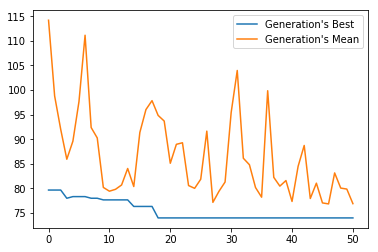

In [31]:
import matplotlib.pyplot as plt

x_points=list(map(lambda x:x[0],best_of))
y_points=list(map(lambda x:x[1]['ticks'],best_of))
z_points=list(map(lambda x:x[1],all_mean))

best_of_all_time_index = np.argmin(y_points)
best_of_all_time = best_of[best_of_all_time_index][1]
best_doors = list(map(lambda i:good_doors[i] ,best_of_all_time['doors']))

print("Best door combination:\n{0}\nticks:{1}\nGeneration:{2}".format(best_doors,best_of_all_time['ticks'],best_of_all_time['gen']))

plt.plot(x_points,y_points,z_points)
plt.legend(["Generation's Best","Generation's Mean"])
plt.show()

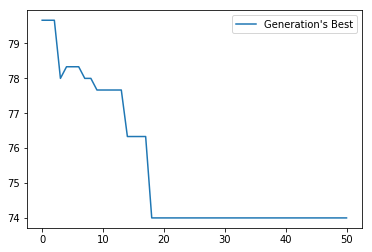

In [32]:
x_points=list(map(lambda x:x[0],best_of))
y_points=list(map(lambda x:x[1]['ticks'],best_of))

plt.plot(x_points,y_points)
plt.legend(["Generation's Best"])
plt.show()

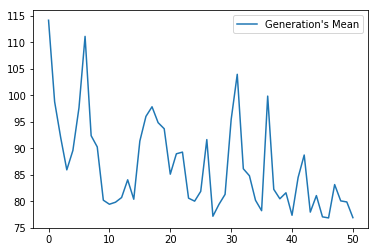

In [33]:
x_points=list(map(lambda x:x[0],all_mean))
y_points=list(map(lambda x:x[1],all_mean))

# print("Best door combination:\n{0}\nticks:{1}".format(best_doors,best_of_all_time['ticks']))

plt.plot(x_points,y_points)
plt.legend(["Generation's Mean"])
plt.show()

In [34]:
# best_of

In [35]:
# all_mean

In [38]:
for x  in range(len(population)):
    print("gen",int(x),":")
    for i in population[x]:
        print(i)


gen 0 :
{'doors': [205, 142, 279, 187, 197], 'gen': 0, 'ticks': 107.0}
{'doors': [292, 159, 266, 103, 102], 'gen': 0, 'ticks': 108.0}
{'doors': [15, 143, 221, 141, 180], 'gen': 0, 'ticks': 124.33333333333333}
{'doors': [239, 24, 2, 296, 184], 'gen': 0, 'ticks': 104.66666666666667}
{'doors': [334, 224, 252, 269, 10], 'gen': 0, 'ticks': 162.0}
{'doors': [103, 40, 320, 304, 229], 'gen': 0, 'ticks': 93.66666666666667}
{'doors': [318, 176, 56, 291, 107], 'gen': 0, 'ticks': 121.33333333333333}
{'doors': [161, 203, 255, 312, 162], 'gen': 0, 'ticks': 92.33333333333333}
{'doors': [172, 187, 112, 186, 20], 'gen': 0, 'ticks': 142.66666666666666}
{'doors': [36, 188, 287, 136, 252], 'gen': 0, 'ticks': 98.33333333333333}
{'doors': [131, 109, 154, 79, 5], 'gen': 0, 'ticks': 144.0}
{'doors': [313, 15, 343, 49, 84], 'gen': 0, 'ticks': 101.0}
{'doors': [85, 74, 93, 11, 242], 'gen': 0, 'ticks': 122.66666666666667}
{'doors': [13, 136, 235, 111, 242], 'gen': 0, 'ticks': 112.0}
{'doors': [94, 141, 276, 119,

In [19]:
kill_netlogo()